# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
+ Formulas for the Bernoulli distribution: https://en.wikipedia.org/wiki/Bernoulli_distribution

In [1]:
# import libraries
import pandas as pd
import numpy as np
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set()

In [2]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [3]:
# number of callbacks for black-sounding names
print('white:',sum(data[data.race=='w'].call), '\nblack:', sum(data[data.race=='b'].call))

white: 235.0 
black: 157.0


In [4]:
data.head()

,id,ad,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,...,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind,ownership
0,b,1,4,2,6,0,0,0,1,17,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
1,b,1,3,3,6,0,1,1,0,316,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
2,b,1,4,1,6,0,0,0,0,19,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
3,b,1,3,4,6,0,1,0,1,313,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
4,b,1,3,3,22,0,0,0,0,313,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Nonprofit


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4870 entries, 0 to 4869
Data columns (total 65 columns):
id                    4870 non-null object
ad                    4870 non-null object
education             4870 non-null int8
ofjobs                4870 non-null int8
yearsexp              4870 non-null int8
honors                4870 non-null int8
volunteer             4870 non-null int8
military              4870 non-null int8
empholes              4870 non-null int8
occupspecific         4870 non-null int16
occupbroad            4870 non-null int8
workinschool          4870 non-null int8
email                 4870 non-null int8
computerskills        4870 non-null int8
specialskills         4870 non-null int8
firstname             4870 non-null object
sex                   4870 non-null object
race                  4870 non-null object
h                     4870 non-null float32
l                     4870 non-null float32
call                  4870 non-null float32
city        

### What test is appropriate for this problem? Does CLT apply?

The variable that we will be testing is whether or not the applicant got a call back. Since this variable can be coded as a success (callback = 1) or failure (no callback = 0), this is an example of a Bernoulli Trial. To examine the potential presence of racial discrimination, we will use two-sample inference (black-sounding names vs white-sounding names).</p> 

The central limit theorem will apply because the following assumptions are met:  
* Randomization Condition: The race identifier was randomly assigned during the screening process, so the qualification of applicants should be randomly distributed as well.
* Independence Assumption: No applicant should appear in both groups and the presence of one applicant should not have an effect on the following applicants.
* 10% Condition: Our sample size is much smaller than 10% of all job applicants. This also lends evidence to meeting the independence assumption
* Sample Size Assumption: Both sample groups are much larger than 30, so we can assume that our sample size will be large enough.

Since we are using a Bernoulli distribution, the central tendency will group around the probability that the group will receive a callback.

### What are the null and alternate hypotheses?

**H<sub>0</sub>**: There is no racial discrimination in the number of callbacks for applicants (i.e. there is no difference in the probability of a black applicant getting a callback than a white applicant.)

**H<sub>A</sub>**: There is racial discrimination in the number of callback for applicants.

**Significance Level (&alpha;)**: 0.05

In [5]:
w = data[data.race=='w']
b = data[data.race=='b']

In [6]:
# create function to calculate difference of means stats
def diff_of_means_stats(x1, x2, sig=1.96):
    '''
    A function to calculate the difference in means and
    relevant p-value of two Bernoulli samples.
    
    x1 = array of sample data
    x2 = array of sample data to compare with x1
    sig = the z-score used to calculate confidence interval;
          defaults to a 95% confidence interval
    '''
    # compute number of observations
    n1 = len(x1)
    n2 = len(x2)
    
    # Compute sample means / probability of call back
    prob1 = np.mean(x1)
    prob2 = np.mean(x2)

    # Compute estimated probability
    phat = (np.sum(x1) + np.sum(x2)) / (n1 + n2)

    # Compute sample standard error
    sigma = np.sqrt( phat * (1-phat) * (1/n1 + 1/n2) )

    # Compute margin of error
    margin = sig * sigma

    # Compute confidence interval
    diff = prob1 - prob2
    ci_95 = (diff - margin, diff + margin)

    # Compute p-values
    zscore = diff / sigma
    p = stats.norm.cdf(-zscore)*2
    
    return prob1, prob2, diff, sigma, margin, zscore, ci_95, p

# compute difference of means stats for callbacks
prob1, prob2, diff, sigma, margin, zscore, ci_95, p = diff_of_means_stats(w.call, b.call)

In [7]:
print('Sample mean probability of getting a call back: {0:.3f} \
      \nProbability of White applicant getting a call back: {1:.3f} \
      \nProbability of Black applicant getting a call back: {2:.3f} \
      \nDifference of means: {3:.3f}'.format(np.mean(data.call)
                                             , prob1
                                             , prob2
                                             , diff
                                            ))
print('-'*100)
print('Standard error: {0:.4f}'.format(sigma))
print('-'*100)
print('Margin of error: {0:.4f}'.format(margin))
print('-'*100)
print('95% confidence interval: ({0:.5f}, {1:.5f})'.format(ci_95[0], ci_95[1]))
print('-'*100)
print('z-score: {0:.7f}\np-value: {1:.7f}'.format(zscore, p))

Sample mean probability of getting a call back: 0.080       
Probability of White applicant getting a call back: 0.097       
Probability of Black applicant getting a call back: 0.064       
Difference of means: 0.032
----------------------------------------------------------------------------------------------------
Standard error: 0.0078
----------------------------------------------------------------------------------------------------
Margin of error: 0.0153
----------------------------------------------------------------------------------------------------
95% confidence interval: (0.01675, 0.04731)
----------------------------------------------------------------------------------------------------
z-score: 4.1084122
p-value: 0.0000398


In [8]:
# create bootstrap function
def bootstrap_replicates(data, func=np.mean):
    '''
    A function to take a random sample with replacement
    from the original data array and return a sample
    test statistic.
    
    data = array of original data
    func = test statistic, defaults to mean
    '''
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

# create empty array for bootstrapping
bs_replicates = np.empty(10000)

# bootstrap 100,000 replicate sample means
for i in range(10000):
    bs_replicates[i] = bootstrap_replicates(data=data.call)

(0, 1)

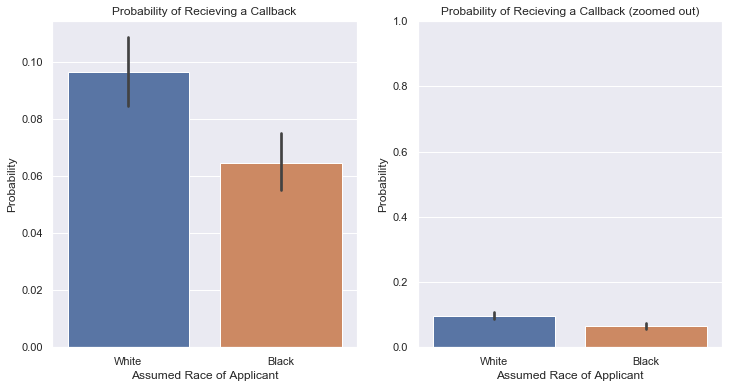

In [11]:
# plot the probability of getting a callback
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
ax1 = plt.subplot(121)
sns.barplot(x='race', y='call', data=data, ax=ax1)
ax1.set_xticklabels(['White', 'Black'])
ax1.set_xlabel('Assumed Race of Applicant')
ax1.set_ylabel('Probability')
ax1.set_title('Probability of Recieving a Callback', fontsize=12)

# plot the probability of getting a callback on 0-to-1 scale
ax2 = plt.subplot(122)
sns.barplot(x='race', y='call', data=data, ax=ax2)
ax2.set_xticklabels(['White', 'Black'])
ax2.set_xlabel('Assumed Race of Applicant')
ax2.set_ylabel('Probability')
ax2.set_title('Probability of Recieving a Callback (zoomed out)', fontsize=12)
ax2.set_ylim(bottom=0, top=1)

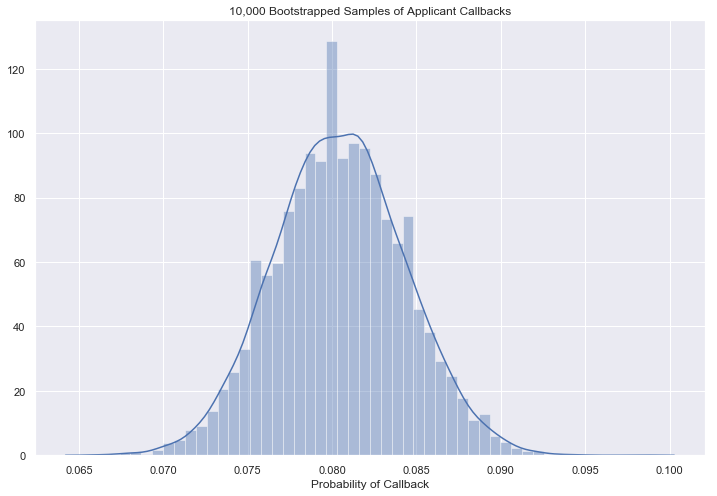

In [12]:
# draw a PDF of the bootstrap sample means
plt.figure(figsize=(12,8))
ax1 = sns.distplot(bs_replicates)
ax1 = plt.xlabel('Probability of Callback')
ax1 = plt.title('10,000 Bootstrapped Samples of Applicant Callbacks')

plt.savefig('img/bootstrap_call_distro.png')

In [13]:
# bootstrap White applicants
bs_w = np.empty(10000)

# bootstrap 100,000 replicate sample means
for i in range(10000):
    bs_w[i] = bootstrap_replicates(data=w.call)

# bootstrap Black applicants
bs_b = np.empty(10000)

# bootstrap 100,000 replicate sample means
for i in range(10000):
    bs_b[i] = bootstrap_replicates(data=b.call)

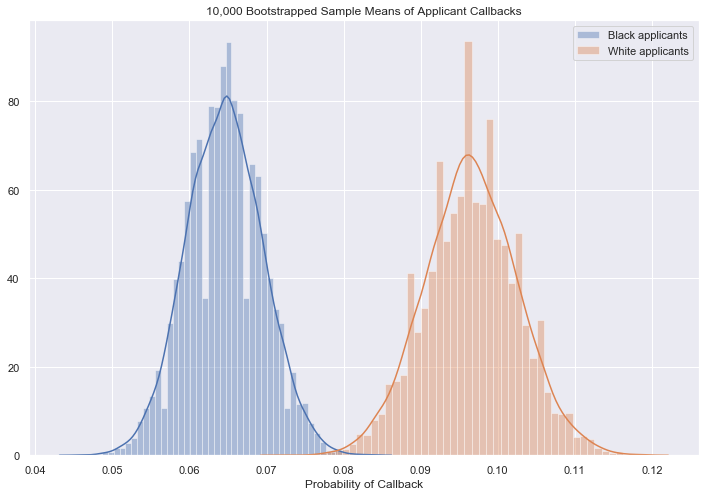

In [14]:
# compare distribution of means for Black and White applicants
plt.figure(figsize=(12,8))
ax2 = sns.distplot(bs_b, label='Black applicants')
ax2 = sns.distplot(bs_w, label='White applicants')
ax2 = plt.xlabel('Probability of Callback')
ax2 = plt.title('10,000 Bootstrapped Sample Means of Applicant Callbacks')
plt.legend()

plt.savefig('img/black_v_white_distro.png')

In [17]:
# create normal distribution of sample difference of means
theta = np.sqrt( (np.std(w.call) / len(w.call)) + (np.std(b.call) / len(b.call)) )
sample_normal = np.random.normal(diff, theta, 10000)

# create normal distribution assuming the null hypothesis
null_normal = np.random.normal(0.0, theta, 10000)
null_ci = np.percentile(null_normal, [2.5, 97.5])

pval = np.sum(null_normal >= diff)/10000
print('95% Confidence Interval for Difference of Means')
print('Sample Difference of 0.032:', ci_95)
print('Null Hypothesis Difference of 0.0: ({0:.3f}, {1:.3f})'.format(null_ci[0], null_ci[1]))
print('p-value: {:.4f}'.format(pval))

95% Confidence Interval for Difference of Means
Sample Difference of 0.032: (0.01675094254416648, 0.047314767165954674)
Null Hypothesis Difference of 0.0: (-0.029, 0.030)
p-value: 0.0165


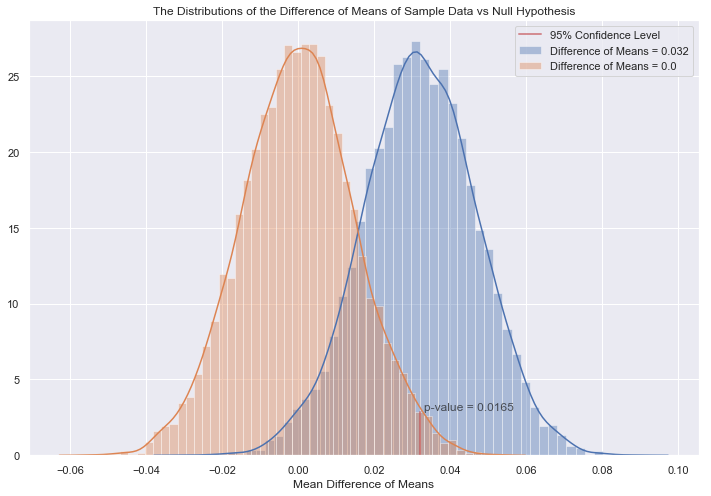

In [18]:
# plot the normal distributions of the difference of means
plt.figure(figsize=(12,8))

ax3 = sns.distplot(sample_normal, label='Difference of Means = 0.032')
sns.distplot(null_normal, label='Difference of Means = 0.0', ax=ax3)
ax3 = plt.axvline(x=diff, ymax=0.10, linewidth=2, color='r', alpha=0.6, label='95% Confidence Level')
ax3 = plt.annotate('p-value = {}'.format(pval), xy=(diff+0.001, 3.0), color='k', alpha=0.7, fontsize=12)
ax3 = plt.title('The Distributions of the Difference of Means of Sample Data vs Null Hypothesis')
ax3 = plt.xlabel('Mean Difference of Means')
ax3 = plt.legend()

plt.savefig('img/diff_of_means_distros.png')

## Closing Remarks
To restate, our null hypothesis is that their is no racial discrimination in the amount of callbacks received during the initial application process. To test this, we assumed that the probability of a White applicant receiving a callback is equal to that of a Black applicant (p&#770;<sub>1</sub> - p&#770;<sub>2</sub> = 0). We set our significance level at 0.05.

Using frequentist methods of analysis, we see that our sample difference of probability (0.032) has a p-value of 0.0018. In other words, if we assume the nul hypothesis to be true, then we would expect to see a difference this large less than 0.2% of the time. If we perform a boostrap analysis, generating 10,000 sample probabilities, we get a p-value of 0.0132. Although this is much higher than our sample p-value, both are well below our significance level of 0.05, so we reject the null hypothesis and state that there is significant evidence to suggest that their may be racial discrimination in the callback process.

Although our analysis suggests that the racial assumptions about names are an important factor in the callback success, we do not yet have sufficient analysis to determine whether this is the most important factor. Because the names were randomized, we can assume that the other variables did not play a role in the callback success rate, but to be more certain we would need to perform multivariate analysis. 